In [1]:
import torch
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import google.generativeai as genai


# Build the detection prompt

In [2]:
from typing import List, Dict, Any

def build_detection_prompt(submission: str):
    """
    Build a structured prompt for classifying submissions as Human, AI, or Hybrid.
    """
    role = f'You are an impartial AI text detector evaluating whether a given text is AI- or human-generated or Hybrid.'
    task = 'Classify the text and provide reasoning for your decision.”'   
    step =  """
    Step 1: Analyze the text’s linguistic patterns and style. 
    Step 2: Compare patterns to typical AI-generated and human-written texts. 
    Step 3: Determine the label (AI-generated or human-written). 
    Step 4: Provide reasoning"""

    system_prompt = f"""
    {role}
    Your task is to {task}
    Following the {step}

    Take the input:
        - 'Submission' which is submission.
        
    Then output in this exact format (JSON):
        {{
            "label": "AI" or "Human" or "Hybrid",
            "reasoning": ["first reason", "second reason"]
        }}
    
    """

    user_prompt = f'This the submission {submission}. Base on that provided me result'
    return {
        "system": system_prompt,
        "user": user_prompt}


# Build the feedback generative prompt

In [3]:
def build_feedback_prompt(rubric: str, submission: str) -> List[Dict[str, str]]:
    """
    Build a structured prompt for rubric-aligned feedback generation.
    """
    role = f"You are a helpful and respectful educational assessment assistant that provides feedback on submitted work. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Provide assessment feedback and a rating for the assessment based on performce descriptors."
    task = "Analyze the student’s response and generate detailed, actionable feedback"
    step = """
    Summarize overall performance in 2-4 sentences of the input submission.
    Then provided the feedback based on the criterion
    For each rubric criterion:
    •	Identify rating (excellent to poor)
    •	Provide evidence from the submission (1-3 points)
    •	Give one concrete improvement tip
    """
    system = f"""
    {role} and your task is to {task}.
    
    Following the below step: {step}
    
    Take the input as a text submission of the task and provide the output as these following:
      1) Overall Summary: 2–4 sentences on strengths and priorities.
      2) Criteria Feedback: For each rubric criterion, include:
          - Criterion
          - Rating (excellent, good, average, needs_improvement, poor)
          - Evidence (1–3 bullet points citing excerpts or behaviors)
"""
    user = f"This is the submission of the student {submission} and provide the output"
    return {
        "system": system,
        "user": user}

## Extract the rubric

In [4]:
def format_rubric(rubric):
    formatted_rubric = f"""
    Rubric ID: {rubric['rubric_id']}
  
    Criteria:
    """
  
    for rubric_item in rubric['criteria']:
      formatted_rubric += f"""
      Criterion: {rubric_item['criterion_id']}
      Name: {rubric_item['name']}
      Description: {rubric_item['description']}
      Performance Descriptors:
      """
      for key, val in rubric_item['performance_descriptors'].items():
        formatted_rubric += f"""
        - {key}: {val}
        """
    return formatted_rubric

In [5]:
from huggingface_hub import login

def generate_result(model, tokenizer, text, device = 'cuda'):
    model.to(device)
    inputs = tokenizer.apply_chat_template(
                    text,
                    add_generation_prompt=True,
                    tokenize=True,
                    return_dict=True,
                    return_tensors="pt",
                ).to(device)
    output_ids = model.generate(**inputs, max_new_tokens=800)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    prompt_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
    return generated_text[len(prompt_text):].strip()

In [6]:
import json
import re

def parse_ai_detection_result(generated_text: str):

    # Remove markdown-style code fences if present
    cleaned = re.sub(r"^```json|^```|```$", "", generated_text.strip(), flags=re.MULTILINE).strip()

    # Try to load as JSON
    try:
        pred_json = json.loads(cleaned)
    except json.JSONDecodeError:
        # Fallback: extract first JSON object found in text
        match = re.search(r'\{.*\}', cleaned, re.DOTALL)
        if not match:
            raise ValueError("No valid JSON object found in response")
        pred_json = json.loads(match.group())

    prediction = pred_json['label']
    reasoning = pred_json['reasoning']
    return prediction, reasoning


# Load the model 

In [ ]:
import os

# Set your API key (from Google AI Studio / Cloud console)
genai.configure(api_key="")

# Choose model: "gemini-1.5-pro" or "gemini-1.5-flash"


def generated_response_gemini(message):
    model = genai.GenerativeModel("gemini-1.5-flash",system_instruction= message['system'])
    chat = model.start_chat()
    response = chat.send_message(message['user'])
    return response.text

# Run the model on the test dataset to get result.

In [ ]:
domains = ['engineering', 'it','psychology', 'teaching'] #'engineering', 'it','psychology', 'teaching', 'accounting'
path = 'Training_Data/'

os.makedirs('run/Detection_AI', exist_ok=True)
os.makedirs('run/Feedback_Gen', exist_ok=True)

#Go through different domain and its json file
for domain in domains:
    file = path + domain + '.json' #Create the json file
    with open(file, 'r') as file:
        data = json.load(file) #Get the data file

    #Get the rubric of the domain
    rubric = format_rubric(data['rubric'])

    ai_results = []
    gen_results = []
    for s in tqdm(data["submissions"]):
        text = s.get("final_submission", "")
        label = s.get("label_type", "")
        #build prompt for this submission
        detector_prompt = build_detection_prompt(submission = text) #AI dection prompt
        feedback_prompt = build_feedback_prompt(submission = text, rubric = rubric) #Feedback generation AI


        # Run AI Detector and Feedback AI
        ai_pred, _ = parse_ai_detection_result(generated_response_gemini(message= detector_prompt))
        feedback_result = generated_response_gemini(message= feedback_prompt)

        #Save the result
        ai_results.append({ "text": text, "labels": label, "predictions": ai_pred})
        gen_results.append({"text": text, "generated_text": feedback_result, "rubric": rubric})
    print("Saving to file")
    #Save the result to CSV file
    detection_df = pd.DataFrame(ai_results)
    gen_df = pd.DataFrame(gen_results)
    detection_df.to_csv(f"run/Detection_AI/{domain}.csv")
    gen_df.to_csv(f'run/Feedback_Gen/{domain}.csv')
    display(detection_df)
    display(gen_df)

# Evaluate the performance of the model

***************** teaching *****************


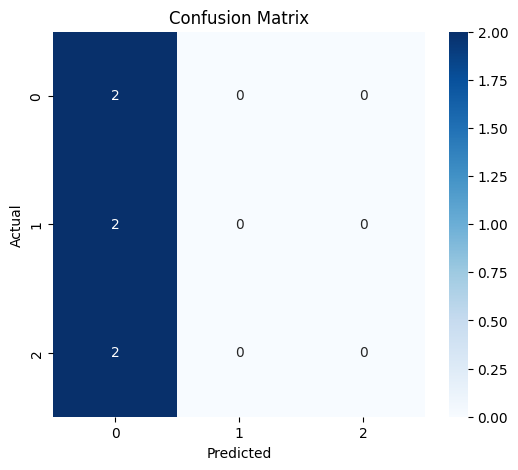

Accuracy: 0.3333
F1-score: 0.1667
Recall: 0.3333
Precision: 0.1111

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

```json
{
  "result": "Incorrect (AI did not match Human)",
  "reasoning": {
    "Repetition": "No significant repetition.  While some concepts are reiterated (e.g., importance of early literacy development), it's done naturally to emphasize different aspects.",
    "Lexical Diversity": "High lexical diversity. Uses both specialized terms ('phonological awareness', 'phonemic segmentation', 'dialogic reading') and common vocabulary, demonstrating a sophisticated vocabulary.",
    "Sentence Structure Diversity": "Sentence st

In [20]:
from evaluate_model_genai import EvaluateModel

domains = ['teaching'] #'engineering', 'it','psychology', 'teaching', 'accounting'
ai_path = 'run/Detection_AI'
store_path = 'save/Detection_AI'
os.makedirs(store_path, exist_ok=True)

for domain in domains:
    print(f"***************** {domain} *****************")
    dataset_path = ai_path + '/' + domain + '.csv'
    testset = pd.read_csv(dataset_path)
    
    evaluateModel = EvaluateModel(
        dataset=testset,
        model_type="ai_detection",
        device="automap"   # feedback_generation/ai_detection
    )
    
    evaluateModel.evaluate_classification_model(print_result=True)
    evaluateModel.construct_data_message()  # Create the prompt for the dataset

    output_file = os.path.join(store_path, f"{domain}_results.txt")
    with open(output_file, "w", encoding="utf-8") as f:
        for prompt in evaluateModel.dataset_prompt:
            result = generated_response_gemini(prompt)
            try:
                pred_json = json.loads(result)
                confidence = pred_json.get("confidence_level", "N/A")
                f.write(json.dumps(pred_json, ensure_ascii=False) + "\n")
                print(f"confidence_level: {confidence}")
            except:
                # Store raw text if JSON parsing fails
                f.write(result.strip() + "\n")
                print(result)
    
    print(f"Results saved to {output_file}")



In [ ]:
import pandas as pd
import json

from evaluate_model_genai import EvaluateModel

domains = ['psychology', 'teaching']
ai_path = 'run/Feedback_Gen'

for domain in domains:
    print(f"***************** {domain} *****************")
    dataset_path = ai_path + '/' + domain + '.csv'
    testset = pd.read_csv(dataset_path)

    evaluateModel = EvaluateModel(
        dataset=testset, 
        model_type="feedback_generation",  # or "ai_detection"
        device="automap"
    )
    evaluateModel.construct_data_message()  # Create the prompt for the dataset

    # open plain text file for saving results
    output_file = f"results_{domain}.txt"
    with open(output_file, "w", encoding="utf-8") as f:
        for prompt in evaluateModel.dataset_prompt:
            result = generated_response_gemini(prompt)
            try:
                pred_json = json.loads(result)
                line = f"Overall: {pred_json.get('Overall', 'N/A')}\n"
            except Exception:
                # if not valid JSON, just dump raw result
                line = result.strip() + "\n"

            print(line.strip())
            f.write(line)
